In [40]:
import numpy as np
import networkx as nx
import pysindy as ps
from sklearn.metrics import pairwise_distances
import pickle

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Set environment variable for NumPy (optional, for performance as in code)
#os.environ["OMP_NUM_THREADS"] = "1"

# Parameters
n = 50          # Number of nodes (small for toy model)
m = 2           # Dimensions per node (Rulkov: u, v)
time = 500      # Time steps for data
transient = 10000  # Transient steps to discard
beta = 4.1      # Rulkov parameter for chaotic dynamics
mu = 0.001      # Rulkov parameter
sigma = 0.001   # Rulkov parameter
C = 0.1         # Coupling strength (weak)
gamma = 0.001   # Noise amplitude
eta = 0.2       # Weight variation for network edges

# Storage dictionary for results
storage = {
    "adj_matrix": [],
    "laplacian_matrix": [],
    "delta": [],
    "data": [],
    "dist_matrix": [],
    "Fx": [],
    "Y_hub": [],
    "Y": [],
    "predicted_laplacian": []
}

# Output file
filename = f"../data/statistics_data/statistics_gamma_{gamma}.pkl"
f = open(filename, 'wb')

In [41]:
def network_generate(n, eta):
    # Generate scale-free directed graph
    G = nx.scale_free_graph(n, alpha=0.2, beta=0.3, gamma=0.5)
    # Remove self-loops
    G.remove_edges_from(nx.selfloop_edges(G))
    # Remove multi-edges (keep first edge per pair)
    edges_to_remove = []
    seen = set()
    for edge in G.edges:
        if (edge[0], edge[1]) in seen:
            edges_to_remove.append(edge)
        else:
            seen.add((edge[0], edge[1]))
    G.remove_edges_from(edges_to_remove)
    # Assign random weights
    for edge in G.edges(data=True):
        edge[2]["weight"] = np.random.uniform(1.0 - eta, 1.0 + eta)
    # Adjacency matrix (transposed as in paper: w_ij from j to i)
    A = nx.adjacency_matrix(G).todense().T
    # In-degrees (weighted)
    k_in = np.zeros(n)
    for node in range(n):
        if G.in_degree(node) > 0:
            k_in[node] = sum(data["weight"] for _, _, data in G.in_edges(node, data=True))
    # Laplacian: L = diag(k_in) - A
    L = np.diag(k_in) - A
    delta = np.max(k_in)
    return G, A, k_in, L, delta

# Generate one network realization
G, A, k_in, L, delta = network_generate(n, eta)
storage["adj_matrix"].append(A)
storage["laplacian_matrix"].append(L)
storage["delta"].append(delta)

# Print for verification
print("Adjacency matrix shape:", A.shape)
print("Laplacian matrix shape:", L.shape)
print("Max in-degree (delta):", delta)

Adjacency matrix shape: (50, 50)
Laplacian matrix shape: (50, 50)
Max in-degree (delta): 4.1326778263493305


In [42]:
from scipy import sparse

# Define x_noise before calling the function
x_noise = np.zeros(n * m)
x_noise[::2] = 1  # Noise on u-component (even indices: u1, v1, u2, v2, ...)

def data_generate(n, m, transient, time, beta, mu, sigma, C, L, delta, h, gamma, x_noise):
    def rulkov_map(x):
        x = x.reshape(n, m).T
        return np.asarray([
            beta / (1 + x[0]**2) + x[1],
            x[1] - mu * x[0] - sigma
        ]).T.flatten()

    def net_dynamics(x):
        return rulkov_map(x) - (C / delta) * sparse.kron(L, h).dot(x) + x_noise * gamma * np.random.uniform(-1, 1, n * m)

    # Initialize
    x0 = np.random.uniform(0.0, 1.0, n * m)  # Flattened: [u1, v1, u2, v2, ...]
    # Transient for isolated dynamics
    for _ in range(transient):
        x0 = rulkov_map(x0)
    # Transient for coupled dynamics
    for _ in range(transient):
        x0 = net_dynamics(x0)
    # Simulate
    x = np.zeros((n * m, time))
    x[:, 0] = x0
    for t in range(time - 1):
        x[:, t + 1] = net_dynamics(x[:, t])
    return x.reshape(n, m, time)

# Coupling matrix h (x-directional)
h = np.eye(m)
h[1, 1] = 0

# Generate data
x = data_generate(n, m, transient, time, beta, mu, sigma, C, L, delta, h, gamma, x_noise)
storage["data"].append(x)

# Verify
print("Data shape:", x.shape)  # Should be (n, m, time) = (20, 2, 500)

Data shape: (50, 2, 500)


In [43]:
from scipy import sparse
from sklearn.linear_model import Lasso
from pysindy.optimizers import BaseOptimizer

# Custom optimizer to use sklearn's Lasso with PySINDy
class LassoOptimizer(BaseOptimizer):
    def __init__(self, alpha=0.0001, fit_intercept=False, max_iter=100000, **kwargs):
        super().__init__(**kwargs)
        self.lasso = Lasso(alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter)

    def _reduce(self, x, y):
        self.lasso.fit(x, y)
        self.coef_ = self.lasso.coef_
        self.ind_ = np.abs(self.coef_) > 1e-10  # Threshold for non-zero coefficients
        return self

def data_split(n, x):
    X = x[:, :, :-1]  # x(t)
    dx = x[:, :, 1:]  # x(t+1)
    return X, dx

def predicted_models(n, X, dx, time):
    # Define custom library functions (SM Sec. VIII)
    library_functions = [
        lambda x: np.sin(x),
        lambda x: np.cos(x),
        lambda x: 1 / (1 - x),
        lambda x: 1 / (1 - x**2),
        lambda x: 1 / ((1 - x)**2),
        lambda x: 1 / (1 + x),
        lambda x: 1 / (1 + x**2),  # Critical for Rulkov
        lambda x: 1 / ((1 + x)**2),
        lambda x: 1 / x
    ]
    library_function_names = [
        lambda x: f'sin({x})',
        lambda x: f'cos({x})',
        lambda x: f'1/(1-{x})',
        lambda x: f'1/(1-{x}^2)',
        lambda x: f'1/(1-{x})^2',
        lambda x: f'1/(1+{x})',
        lambda x: f'1/(1+{x}^2)',
        lambda x: f'1/(1+{x})^2',
        lambda x: f'1/{x}'
    ]
    # Combine custom and polynomial libraries
    lib_custom = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
    lib_poly = ps.PolynomialLibrary(degree=1, include_bias=True, include_interaction=False)
    lib = ps.GeneralizedLibrary(
        [lib_custom, lib_poly],
        inputs_per_library=[[0, 0], [0, 1]]  # List to avoid warning
    )

    coeff = []
    t = np.arange(time - 1)  # Time array for discrete-time fitting
    for i in range(n):
        model = ps.SINDy(
            feature_library=lib,
            optimizer=LassoOptimizer(alpha=0.0001, fit_intercept=False, max_iter=100000),
            discrete_time=True
        )
        model.fit(X[i].T, t, x_dot=dx[i].T)  # Add time array t
        coeff.append(model.coefficients())
    return np.array(coeff)

# Split data
X, dx = data_split(n, x)
# Fit models
pred_models = predicted_models(n, X, dx, time)
print("Model coefficients shape:", pred_models.shape)  # Should be (n, m, num_features)

Model coefficients shape: (50, 2, 12)


In [44]:
def similarity(n, x, coeff, k_in):
    # Ground-truth correlation (for reference, not used in classification)
    corr_matrix_gt = np.corrcoef(x[:, 0, :], x[:, 0, :])[0:n, 0:n]
    # Distance matrix between model coefficients
    distance_matrix = pairwise_distances(coeff[:, 0, :], metric='seuclidean')
    # Row-sum histogram
    s = np.sum(distance_matrix, axis=1)
    s_gt = np.sum(np.abs(corr_matrix_gt), axis=1)
    hub_id = np.argmax(s)  # Hub: max distance (most different model)
    ld_id = np.argmin(s)   # Low-degree: min distance
    print(f"Predicted hub: {hub_id}, in-degree: {k_in[hub_id]}")
    print(f"Predicted low-degree node: {ld_id}, in-degree: {k_in[ld_id]}")
    return corr_matrix_gt, distance_matrix, s, s_gt, hub_id, ld_id

# Classify
corr_matrix_gt, distance_matrix, s, s_gt, hub_id, ld_id = similarity(n, x, pred_models, k_in)
storage["dist_matrix"].append(distance_matrix)

Predicted hub: 15, in-degree: 2.2689245906421975
Predicted low-degree node: 18, in-degree: 0.0


In [45]:
def learn_local_dynamics(n, coeff, s):
    # Select low-degree nodes (e.g., bottom 50% of s)
    threshold = np.percentile(s, 50)
    low_degree_indices = np.where(s <= threshold)[0]
    # Average their coefficients
    f_coeff = np.mean(coeff[low_degree_indices], axis=0)
    return f_coeff

# Learn f
f_coeff = learn_local_dynamics(n, pred_models, s)
print("Local dynamics coefficients shape:", f_coeff.shape)

Local dynamics coefficients shape: (2, 12)


In [46]:
import numpy as np
import pysindy as ps

def local_dynamics_function(x, coeff, library):
    """
    Compute F_x by evaluating the SINDy library at x and applying coefficients.
    x: Input state, shape (m,) = (2,) for one node at one time.
    coeff: SINDy coefficients, shape (m, num_features) = (2, 12).
    library: SINDy GeneralizedLibrary object from predicted_models.
    Returns: Predicted next state, shape (m,) = (2,).
    """
    # Evaluate library functions at x
    # Reshape x to (1, m) for SINDy
    x_reshaped = x.reshape(1, -1)  # Shape (1, 2)
    features = library.fit_transform(x_reshaped)  # Shape (1, num_features)
    # Apply coefficients: features @ coeff.T
    # features: (1, num_features), coeff.T: (num_features, m)
    return np.dot(features, coeff.T).flatten()  # Shape (m,) = (2,)

def coupling_effect(dx, hub_id, Fx):
    """
    Compute coupling terms: Y_hub for hub node, Y for all nodes.
    dx: Node derivatives, shape (n, m, time-1).
    hub_id: Index of hub node.
    Fx: Predicted local dynamics, shape (n, m, time-1).
    Returns: Y_hub (m, time-1), Y (n, m, time-1).
    """
    Y_hub = dx[hub_id, :, :] - Fx[hub_id, :, :]
    Y = dx - Fx
    return Y_hub, Y

# Re-define the SINDy library (same as in predicted_models)
library_functions = [
    lambda x: np.sin(x),
    lambda x: np.cos(x),
    lambda x: 1 / (1 - x),
    lambda x: 1 / (1 - x**2),
    lambda x: 1 / ((1 - x)**2),
    lambda x: 1 / (1 + x),
    lambda x: 1 / (1 + x**2),
    lambda x: 1 / ((1 + x)**2),
    lambda x: 1 / x
]
library_function_names = [
    lambda x: f'sin({x})',
    lambda x: f'cos({x})',
    lambda x: f'1/(1-{x})',
    lambda x: f'1/(1-{x}^2)',
    lambda x: f'1/(1-{x})^2',
    lambda x: f'1/(1+{x})',
    lambda x: f'1/(1+{x}^2)',
    lambda x: f'1/(1+{x})^2',
    lambda x: f'1/{x}'
]
lib_custom = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
lib_poly = ps.PolynomialLibrary(degree=1, include_bias=True, include_interaction=False)
lib = ps.GeneralizedLibrary([lib_custom, lib_poly], inputs_per_library=np.array([[0, 0], [0, 1]]))

# Compute F_x for all nodes and times
Fx = np.zeros((n, m, time - 1))
for i in range(n):
    for t in range(time - 1):
        Fx[i, :, t] = local_dynamics_function(X[i, :, t], f_coeff, lib)

# Compute coupling effects
Y_hub, Y = coupling_effect(dx, hub_id, Fx)

# Store results
storage["Fx"].append(Fx)
storage["Y_hub"].append(Y_hub)
storage["Y"].append(Y)

# Verify shapes
print("Fx shape:", Fx.shape)  # Should be (n, m, time-1) = (20, 2, 499)
print("Y_hub shape:", Y_hub.shape)  # Should be (m, time-1) = (2, 499)
print("Y shape:", Y.shape)  # Should be (n, m, time-1) = (20, 2, 499)

/Users/artun/Documents/GitHub/network-reconstruction/.venv/lib/python3.13/site-packages/pysindy/feature_library/generalized_library.py:101: UserWarning: inputs_per_library should no longer be passed as a numpy array
  warn(


Fx shape: (50, 2, 499)
Y_hub shape: (2, 499)
Y shape: (50, 2, 499)


In [47]:
from sklearn.linear_model import Lasso
from pysindy.optimizers import BaseOptimizer
import numpy as np
import pysindy as ps

# Custom Lasso optimizer for PySINDy
class LassoOptimizer(BaseOptimizer):
    def __init__(self, alpha=0.0001, fit_intercept=False, max_iter=100000, **kwargs):
        super().__init__(**kwargs)
        self.lasso = Lasso(alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter)

    def _reduce(self, x, y):
        self.lasso.fit(x, y)
        self.coef_ = self.lasso.coef_
        self.ind_ = np.abs(self.coef_) > 1e-10  # Threshold for non-zero coefficients
        return self

def reconstruction(n, m, time, X, Y):
    # Verify input shapes
    print("X shape:", X.shape)  # Expected: (n, m, time-1)
    print("Y shape:", Y.shape)  # Expected: (n, m, time-1)
    
    # Reshape for SINDy: (time-1, n*m)
    X_flat = X.reshape(n * m, time - 1).T  # (time-1, n*m)
    Y_flat = Y.reshape(n * m, time - 1).T  # (time-1, n*m)
    print("X_flat shape:", X_flat.shape)
    print("Y_flat shape:", Y_flat.shape)
    
    # Time array for discrete-time fitting
    t = np.arange(time - 1)
    print("t shape:", t.shape)  # Expected: (time-1,)
    
    # Initialize SINDy with custom Lasso optimizer
    model = ps.SINDy(
        feature_library=ps.IdentityLibrary(),
        optimizer=LassoOptimizer(alpha=0.001, fit_intercept=False),
        discrete_time=True
    )
    
    # Fit model with time array
    model.fit(X_flat, t=t, x_dot=Y_flat)
    
    # Get coefficients (n*m x n*m)
    L_pred = model.coefficients()
    print("L_pred raw shape:", L_pred.shape)
    
    # Extract n x n Laplacian (x-component coupling)
    xxx = np.arange(0, n * m, m)
    xx, yy = np.meshgrid(xxx, xxx)
    L_pred = L_pred[xx, yy]
    print("Extracted L_pred shape:", L_pred.shape)  # Should be (n, n)
    
    return L_pred

# Reconstruct Laplacian
L_pred = reconstruction(n, m, time, X, Y)
storage["predicted_laplacian"].append(L_pred)

# Save storage
pickle.dump(storage, f)
f.close()

X shape: (50, 2, 499)
Y shape: (50, 2, 499)
X_flat shape: (499, 100)
Y_flat shape: (499, 100)
t shape: (499,)


/Users/artun/Documents/GitHub/network-reconstruction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.108e+02, tolerance: 2.914e+00
  model = cd_fast.enet_coordinate_descent(


L_pred raw shape: (100, 100)
Extracted L_pred shape: (50, 50)


In [48]:
def rmse(L, L_pred, C, delta):
    # Ensure shapes match
    print("True L shape:", L.shape)
    print("Predicted L shape:", L_pred.shape)
    error = np.sqrt(np.mean((L - (C / delta) * L_pred)**2))
    return error

# Compute error
error = rmse(L, L_pred, C, delta)
print("RMSE:", error)

True L shape: (50, 50)
Predicted L shape: (50, 50)
RMSE: 0.27680548704368413


# Analyze the results

In [50]:
import numpy as np
import networkx as nx
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from scipy import sparse
import pickle

# Load the saved pickle file
filename = f"../data/statistics_data/statistics_gamma_{gamma}.pkl"
with open(filename, 'rb') as f:
    storage = pickle.load(f)

# Extract data (first realization)
A = storage["adj_matrix"][0]
L = storage["laplacian_matrix"][0]
delta = storage["delta"][0]
x = storage["data"][0]
dist_matrix = storage["dist_matrix"][0]
Fx = storage["Fx"][0]
Y_hub = storage["Y_hub"][0]
Y = storage["Y"][0]
L_pred = storage["predicted_laplacian"][0]

# Compute hub_id
s = np.sum(dist_matrix, axis=1)
hub_id = np.argmax(s)
print(f"Hub ID: {hub_id}")

# Function to simulate with a given Laplacian
def simulate_with_L(L_used, delta, transient, time, beta, mu, sigma, C, h, gamma, x_noise, n, m):
    def rulkov_map(x):
        x = x.reshape(n, m).T
        return np.asarray([
            beta / (1 + x[0]**2) + x[1],
            x[1] - mu * x[0] - sigma
        ]).T.flatten()

    def net_dynamics(x):
        return rulkov_map(x) - (C / delta) * sparse.kron(L_used, h).dot(x) + x_noise * gamma * np.random.uniform(-1, 1, n * m)

    x0 = np.random.uniform(0.0, 1.0, n * m)
    for _ in range(transient):
        x0 = rulkov_map(x0)
    for _ in range(transient):
        x0 = net_dynamics(x0)
    x_sim = np.zeros((n * m, time))
    x_sim[:, 0] = x0
    for t in range(time - 1):
        x_sim[:, t + 1] = net_dynamics(x_sim[:, t])
    return x_sim.reshape(n, m, time)

# Adjust L_pred for simulation (scale and sign to match original L)
L_recon = - (delta / C) * L_pred

Hub ID: 15


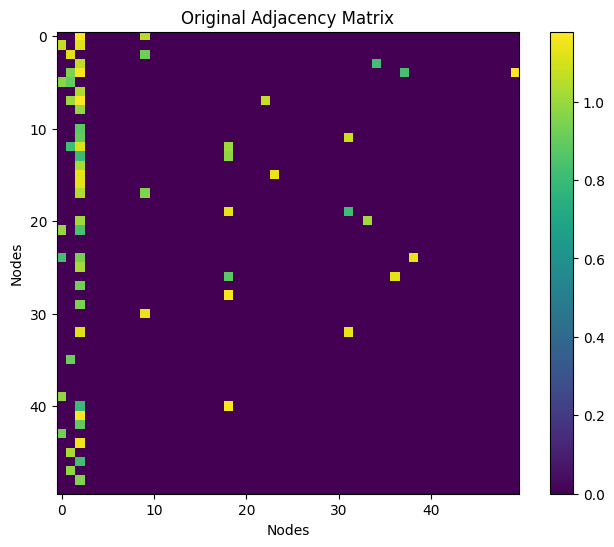

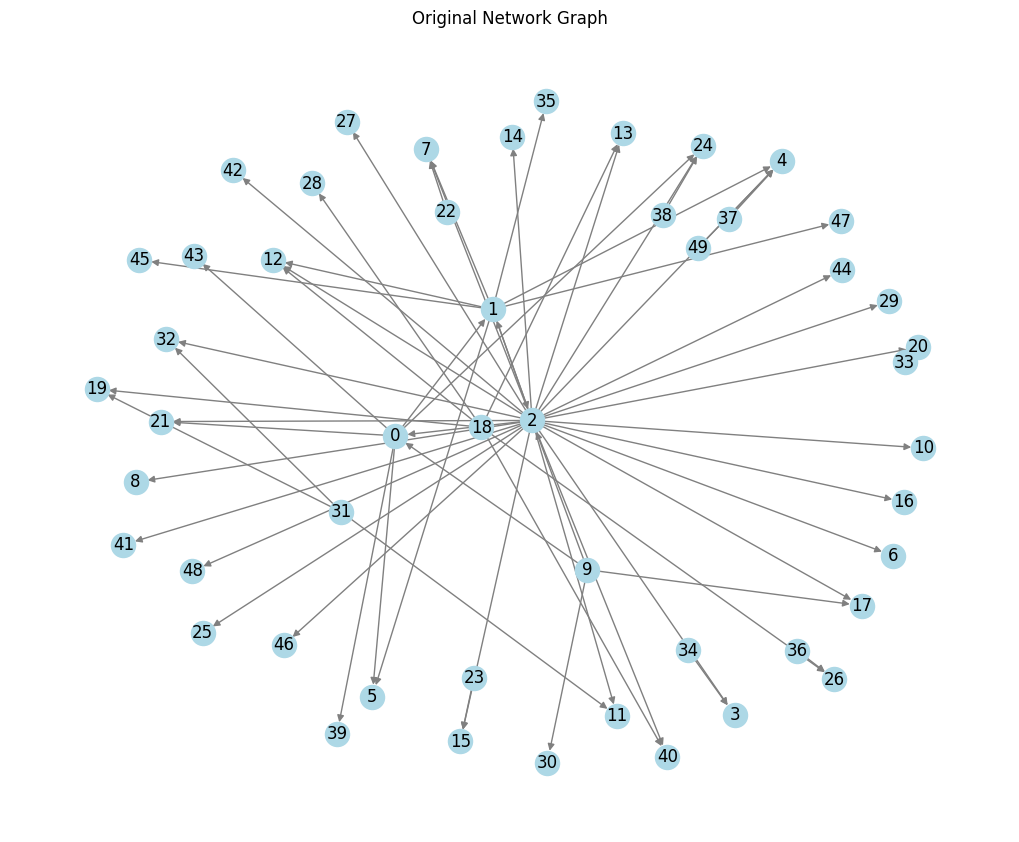

In [51]:
# Heatmap of Adjacency Matrix
plt.figure(figsize=(8, 6))
plt.imshow(A, cmap='viridis')
plt.colorbar()
plt.title('Original Adjacency Matrix')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

# Graph Visualization
G = nx.from_numpy_array(A.T, create_using=nx.DiGraph)  # Transpose for NetworkX convention
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
plt.title('Original Network Graph')
plt.show()

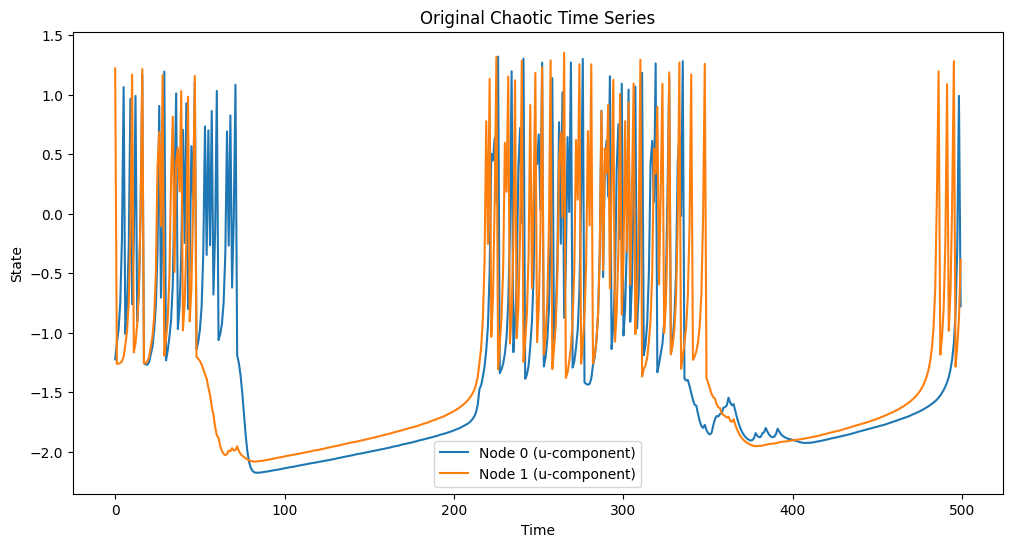

In [52]:
plt.figure(figsize=(12, 6))
for i in range(min(2, n)):
    plt.plot(x[i, 0, :], label=f'Node {i} (u-component)')
plt.title('Original Chaotic Time Series')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

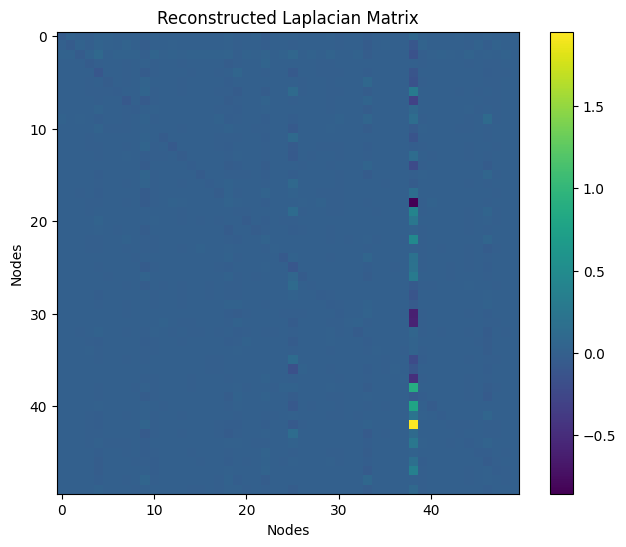

In [53]:
plt.figure(figsize=(8, 6))
plt.imshow(L_pred, cmap='viridis')
plt.colorbar()
plt.title('Reconstructed Laplacian Matrix')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

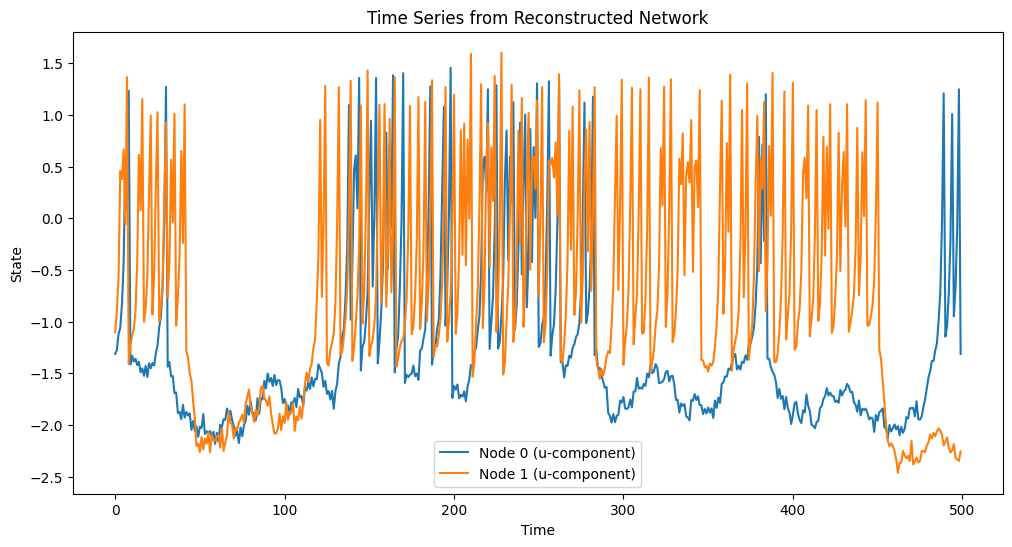

In [54]:
# Generate time series from reconstructed
x_reconstructed = simulate_with_L(L_recon, delta, transient, time, beta, mu, sigma, C, h, gamma, x_noise, n, m)

plt.figure(figsize=(12, 6))
for i in range(min(2, n)):
    plt.plot(x_reconstructed[i, 0, :], label=f'Node {i} (u-component)')
plt.title('Time Series from Reconstructed Network')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

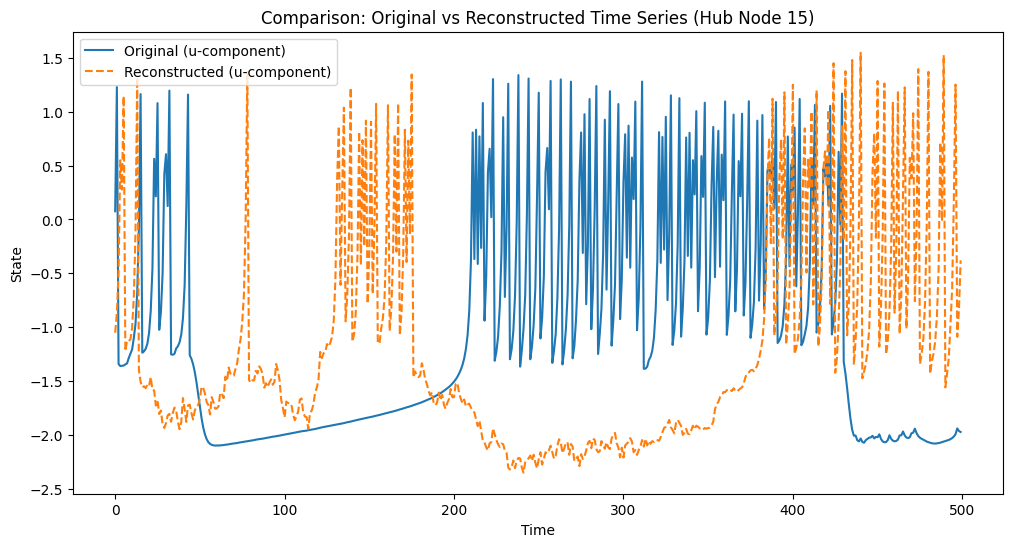

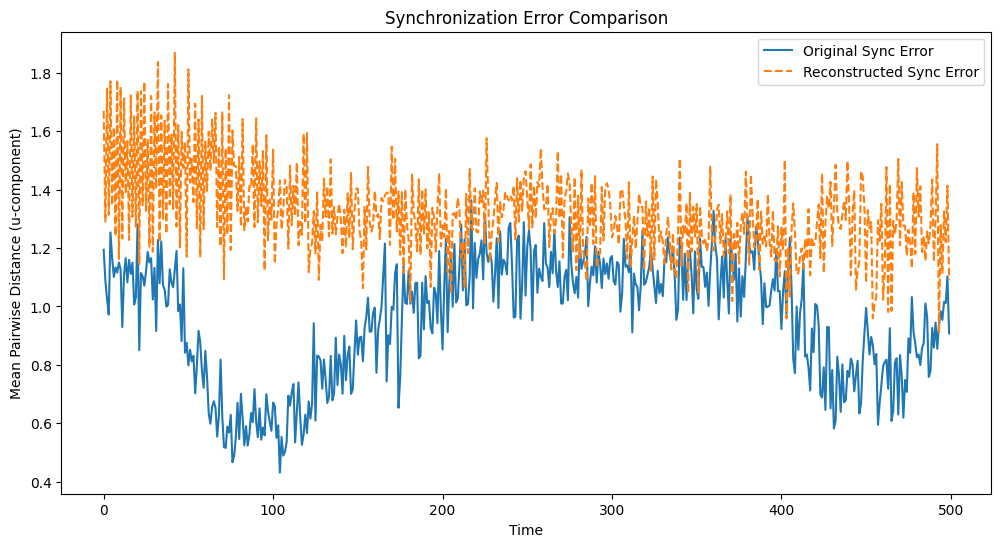

In [55]:
# Comparison for hub node
plt.figure(figsize=(12, 6))
plt.plot(x[hub_id, 0, :], label='Original (u-component)')
plt.plot(x_reconstructed[hub_id, 0, :], label='Reconstructed (u-component)', linestyle='--')
plt.title(f'Comparison: Original vs Reconstructed Time Series (Hub Node {hub_id})')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()

# Synchronization error function
def sync_error(x):
    sync_err = []
    for t in range(x.shape[2]):
        dists = pdist(x[:, 0, t].reshape(-1, 1))
        sync_err.append(np.mean(dists))
    return np.array(sync_err)

original_sync = sync_error(x)
reconstructed_sync = sync_error(x_reconstructed)

plt.figure(figsize=(12, 6))
plt.plot(original_sync, label='Original Sync Error')
plt.plot(reconstructed_sync, label='Reconstructed Sync Error', linestyle='--')
plt.title('Synchronization Error Comparison')
plt.xlabel('Time')
plt.ylabel('Mean Pairwise Distance (u-component)')
plt.legend()
plt.show()

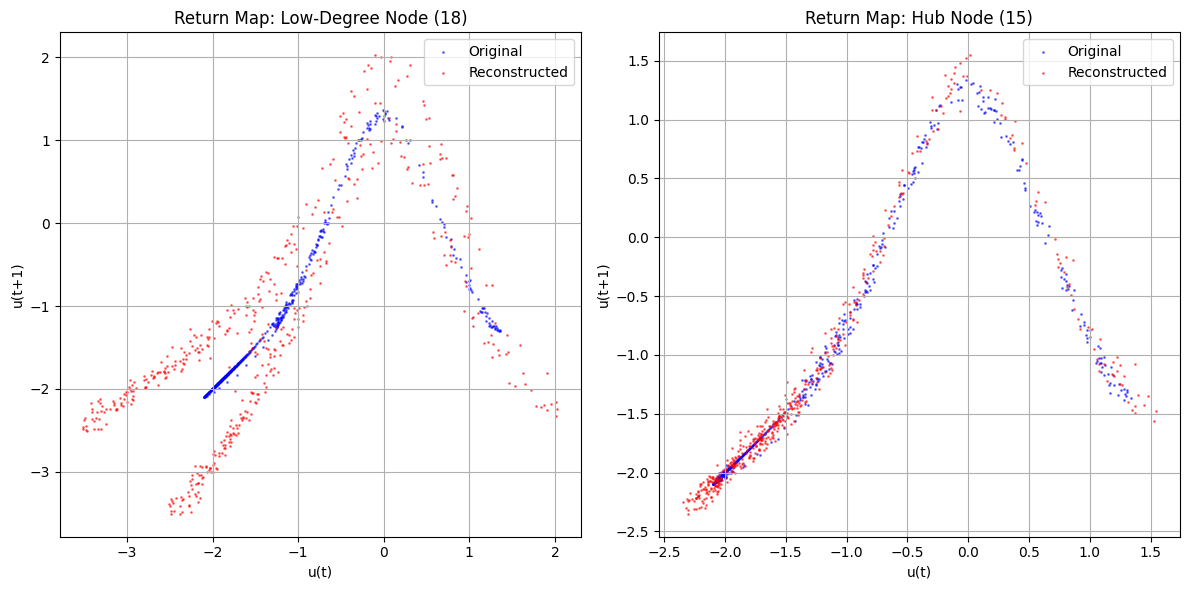

In [62]:
import matplotlib.pyplot as plt

# Compute low-degree node ID (using original classification)
ld_id = np.argmin(s)

# Extract u-components (first dimension) for original and reconstructed data
u_orig = x[:, 0, :]  # Shape: (n, time)
u_recon = x_reconstructed[:, 0, :]  # Shape: (n, time)

# Prepare data for return maps
u_orig_ld = u_orig[ld_id, :-1]  # u(t) for low-degree (original)
u_next_orig_ld = u_orig[ld_id, 1:]  # u(t+1) for low-degree (original)
u_recon_ld = u_recon[ld_id, :-1]  # u(t) for low-degree (reconstructed)
u_next_recon_ld = u_recon[ld_id, 1:]  # u(t+1) for low-degree (reconstructed)
u_orig_hub = u_orig[hub_id, :-1]  # u(t) for hub (original)
u_next_orig_hub = u_orig[hub_id, 1:]  # u(t+1) for hub (original)
u_recon_hub = u_recon[hub_id, :-1]  # u(t) for hub (reconstructed)
u_next_recon_hub = u_recon[hub_id, 1:]  # u(t+1) for hub (reconstructed)

# Note: Using original hub_id and ld_id. For accuracy, reidentify by refitting models to x_reconstructed,
# recomputing dist_matrix and s, then updating hub_id/ld_id.

plt.figure(figsize=(12, 6))

# Low-degree node
plt.subplot(1, 2, 1)
plt.scatter(u_orig_ld, u_next_orig_ld, s=1, c='blue', alpha=0.5, label='Original')
plt.scatter(u_recon_ld, u_next_recon_ld, s=1, c='red', alpha=0.5, label='Reconstructed')
plt.title(f'Return Map: Low-Degree Node ({ld_id})')
plt.xlabel('u(t)')
plt.ylabel('u(t+1)')
plt.legend()
plt.grid(True)

# Hub node
plt.subplot(1, 2, 2)
plt.scatter(u_orig_hub, u_next_orig_hub, s=1, c='blue', alpha=0.5, label='Original')
plt.scatter(u_recon_hub, u_next_recon_hub, s=1, c='red', alpha=0.5, label='Reconstructed')
plt.title(f'Return Map: Hub Node ({hub_id})')
plt.xlabel('u(t)')
plt.ylabel('u(t+1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()